In [118]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_val_score, cross_validate, KFold, GridSearchCV
from sklearn.linear_model import PoissonRegressor, LinearRegression,GammaRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_poisson_deviance
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor



In [123]:
def prepare_data(file_path,cols = None,idx = 'FIPS',target = 'EVICTIONS',dropna=True):

    df = pd.read_csv(file_path)
    df = df.sample(frac=1,random_state = 12)
  
    df[['AFAM','HISPANIC','WHITE','NUM_LOANS']] = (df[['AFAM','HISPANIC','WHITE','NUM_LOANS']]\
                                          .div(df['POPULATION'],axis=0))*100
    
    if dropna:  
        df.dropna(inplace=True)#Inpute missing is better
    
    if cols is not None:
        df = df[cols+[idx,target]]
        
    X,y = df.drop([idx,target],axis=1),df[target]

    return X,y

In [124]:


cols = ['POPULATION',
       'EP_UNEMP',
       'EP_PCI',
       'EP_NOVEH',
       'EP_MOBILE',
       'EP_CROWD',
       'EP_AGE65',
       'EP_AGE17',
       'AFAM',
       'WHITE',
       'HISPANIC',
       'WFIR_EALT',
       'HRCN_EALT',
       'CFLD_EALT',
       'RFLD_EALT',
       'HWAV_EALT']


X_train, y_train = prepare_data("../data/processed/sepher_model_data/train.csv",cols = cols)
m,n = X_train.shape

X_test, y_test = prepare_data("../data/processed/sepher_model_data/test.csv",cols = cols)

In [125]:

temp = sm.add_constant(X_train.copy())
vifs = pd.Series([variance_inflation_factor(temp.values, i) 
               for i in range(temp.shape[1])], 
              index=temp.columns).sort_values(ascending=False)
vifs


const         52.738020
WHITE          1.828988
EP_NOVEH       1.786160
EP_PCI         1.762971
EP_UNEMP       1.699083
EP_CROWD       1.497966
EP_AGE65       1.459273
EP_AGE17       1.387423
HISPANIC       1.358122
HRCN_EALT      1.262773
POPULATION     1.262110
EP_MOBILE      1.253175
RFLD_EALT      1.202136
AFAM           1.145097
WFIR_EALT      1.053169
HWAV_EALT      1.023018
CFLD_EALT      1.002387
dtype: float64

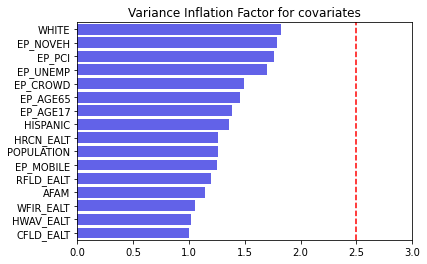

In [165]:
sns.barplot(y=vifs.drop('const').index,
            x=vifs.drop('const').values,
           color='blue',
           alpha=0.7)
plt.axvline(x=2.5,color = 'red',linestyle='--')
plt.title('Variance Inflation Factor for covariates')
plt.xlim(0,3)
plt.show()

# Poisson Regression

In [6]:
pipe_pr = Pipeline([('scaler', StandardScaler()), ('pr', PoissonRegressor(max_iter=10000))])

In [7]:
parameters = {'pr__alpha':np.arange(0,10.1,.1)}
gcv = GridSearchCV(pipe_pr,parameters,cv=10,scoring='neg_mean_absolute_error',n_jobs=-1)
gcv.fit(X_train,y_train)
best_pipe = gcv.best_estimator_
best_pipe.fit(X_train,y_train)
best_pr = best_pipe['pr']

In [8]:
gcv.best_score_,best_pr.alpha

(-14.777772754883083, 5.800000000000001)

In [9]:
y_pred = best_pipe.predict(X_test)

In [10]:
id_outlier = np.where(y_pred==y_pred.max())[0][0]

y_test_l = list(y_test)
y_pred_l = list(y_pred)

y_test_l.pop(id_outlier)
y_pred_l.pop(id_outlier)

455.07266445397283

In [11]:
mean_absolute_error(y_test_l,y_pred_l)

15.026918916865267

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


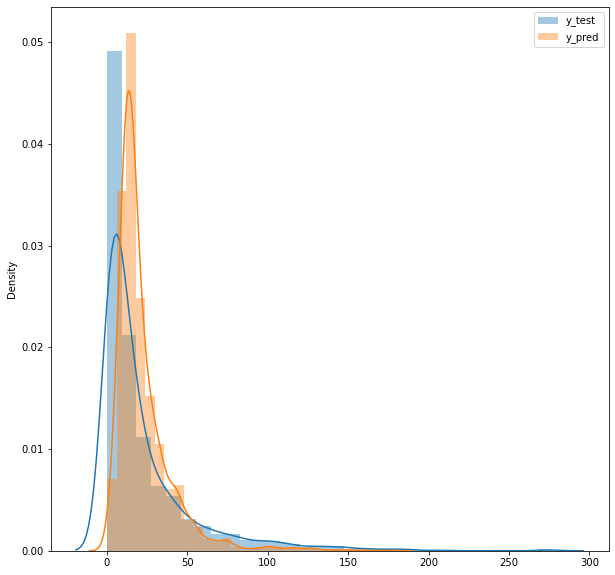

In [12]:
ax = plt.figure(figsize = (10,10))
sns.distplot(x = y_test_l,bins = 30,label = 'y_test')
sns.distplot(x = y_pred_l,bins = 30,label = 'y_pred')
plt.legend()
plt.show()

In [13]:
best_pr_coeffs = pd.DataFrame({'coefs':best_pr.coef_},index = X_train.columns)
best_pr_coeffs['coefs_abs'] = best_pr_coeffs['coefs'].abs()
best_pr_coeffs = best_pr_coeffs\
    .sort_values(by ='coefs_abs',
                 ascending=False)

In [14]:
best_pr_coeffs

,coefs,coefs_abs
WHITE,-0.227537,0.227537
POPULATION,0.225877,0.225877
EP_PCI,-0.191755,0.191755
EP_AGE65,-0.180831,0.180831
EP_NOVEH,0.143531,0.143531
AFAM,0.137840,0.137840
EP_MOBILE,-0.083012,0.083012
EP_UNEMP,0.080499,0.080499
EP_CROWD,0.053151,0.053151
WFIR_EALT,-0.052644,0.052644


# Random Forrest

## Loss = MSE

In [25]:
pipe_rf = Pipeline([('rf', RandomForestRegressor(n_estimators=200,
                                                n_jobs=-1,
                                                random_state = 12,
                                                criterion = 'squared_error'
                                             )
                 )
                ])

In [26]:
max_features = np.unique(np.array([n,3*n/4,n/2,n/3,n/4,np.sqrt(n)])\
                                  .round()\
                                  .astype(int))
min_samples_leaf = 2**np.arange(5)

parameters = {'rf__max_features':max_features,
              'rf__min_samples_leaf':min_samples_leaf
             }

gcv = GridSearchCV(pipe_rf,parameters,cv=10,scoring='neg_mean_absolute_error',verbose=2)
gcv.fit(X_train,y_train)
best_pipe = gcv.best_estimator_
best_pipe.fit(X_train,y_train)
best_model = best_pipe['rf']

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   1.6s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   1.5s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   2.0s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   2.3s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   2.4s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   2.6s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   2.1s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   1.9s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   2.0s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   2.0s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=2; total time=   1.5s
[CV] END .........rf__max_features=4, rf__min_

[CV] END .........rf__max_features=8, rf__min_samples_leaf=1; total time=   6.8s
[CV] END .........rf__max_features=8, rf__min_samples_leaf=1; total time=   6.8s
[CV] END .........rf__max_features=8, rf__min_samples_leaf=1; total time=   6.6s
[CV] END .........rf__max_features=8, rf__min_samples_leaf=1; total time=   6.6s
[CV] END .........rf__max_features=8, rf__min_samples_leaf=1; total time=   6.8s
[CV] END .........rf__max_features=8, rf__min_samples_leaf=1; total time=   5.5s
[CV] END .........rf__max_features=8, rf__min_samples_leaf=1; total time=   4.4s
[CV] END .........rf__max_features=8, rf__min_samples_leaf=1; total time=   5.0s
[CV] END .........rf__max_features=8, rf__min_samples_leaf=1; total time=   4.4s
[CV] END .........rf__max_features=8, rf__min_samples_leaf=2; total time=   4.6s
[CV] END .........rf__max_features=8, rf__min_samples_leaf=2; total time=   4.0s
[CV] END .........rf__max_features=8, rf__min_samples_leaf=2; total time=   4.0s
[CV] END .........rf__max_fe

[CV] END ........rf__max_features=16, rf__min_samples_leaf=1; total time=   4.7s
[CV] END ........rf__max_features=16, rf__min_samples_leaf=1; total time=   4.4s
[CV] END ........rf__max_features=16, rf__min_samples_leaf=1; total time=   4.2s
[CV] END ........rf__max_features=16, rf__min_samples_leaf=1; total time=   4.5s
[CV] END ........rf__max_features=16, rf__min_samples_leaf=1; total time=   4.8s
[CV] END ........rf__max_features=16, rf__min_samples_leaf=1; total time=   4.8s
[CV] END ........rf__max_features=16, rf__min_samples_leaf=1; total time=   4.8s
[CV] END ........rf__max_features=16, rf__min_samples_leaf=2; total time=   4.2s
[CV] END ........rf__max_features=16, rf__min_samples_leaf=2; total time=   4.1s
[CV] END ........rf__max_features=16, rf__min_samples_leaf=2; total time=   4.0s
[CV] END ........rf__max_features=16, rf__min_samples_leaf=2; total time=   5.0s
[CV] END ........rf__max_features=16, rf__min_samples_leaf=2; total time=   5.3s
[CV] END ........rf__max_fea

In [27]:
gcv.best_score_,best_model

(-11.975772714453791,
 RandomForestRegressor(max_features=8, min_samples_leaf=4, n_estimators=200,
                       n_jobs=-1, random_state=12))

In [28]:
gcv.best_score_,best_model

(-11.975772714453791,
 RandomForestRegressor(max_features=8, min_samples_leaf=4, n_estimators=200,
                       n_jobs=-1, random_state=12))

In [29]:
y_pred = best_pipe.predict(X_test)

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


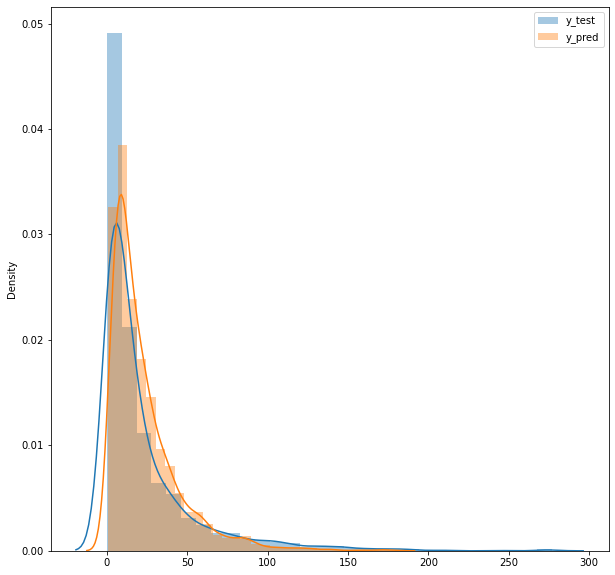

In [30]:
ax = plt.figure(figsize = (10,10))
sns.distplot(x = y_test,bins = 30,label = 'y_test')
sns.distplot(x = y_pred,bins = 30,label = 'y_pred')
plt.legend()
plt.show()

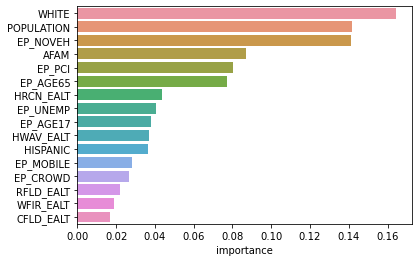

In [33]:
feature_imp = pd.DataFrame({'importance':best_model.feature_importances_},index = X_train.columns)
feature_imp = feature_imp.sort_values(by='importance',ascending=False)
sns.barplot(data = feature_imp,
            x = 'importance',
            y = feature_imp.index)
plt.show()

## Loss = Poisson

In [34]:
max_features = np.unique(np.array([n,3*n/4,n/2,n/3,n/4,np.sqrt(n)])\
                                  .round()\
                                  .astype(int))
min_samples_leaf = 2**np.arange(5)

parameters = {'rf__max_features':max_features,
              'rf__min_samples_leaf':min_samples_leaf
             }



pipe_rf_poi = Pipeline([('rf', RandomForestRegressor(n_estimators=200,
                                                n_jobs=-1,
                                                random_state = 12,
                                                criterion = 'poisson'
                                             )
                 )
                ])

parameters = {'rf__max_features':max_features,
              'rf__min_samples_leaf':min_samples_leaf
             }

gcv_rf_poi = GridSearchCV(pipe_rf_poi,parameters,cv=10,scoring='neg_mean_absolute_error',verbose=2)
gcv_rf_poi.fit(X_train,y_train)
best_pipe_rf_poi = gcv_rf_poi.best_estimator_
best_pipe_rf_poi.fit(X_train,y_train)



Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=  10.1s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=  14.1s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   8.9s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=  11.1s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=  11.0s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   9.1s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   9.2s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   9.7s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   9.9s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   7.9s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=2; total time=   6.6s
[CV] END .........rf__max_features=4, rf__min_

[CV] END .........rf__max_features=8, rf__min_samples_leaf=1; total time=  16.9s
[CV] END .........rf__max_features=8, rf__min_samples_leaf=1; total time=  17.1s
[CV] END .........rf__max_features=8, rf__min_samples_leaf=1; total time=  19.6s
[CV] END .........rf__max_features=8, rf__min_samples_leaf=1; total time=  16.2s
[CV] END .........rf__max_features=8, rf__min_samples_leaf=1; total time=  15.6s
[CV] END .........rf__max_features=8, rf__min_samples_leaf=1; total time=  18.5s
[CV] END .........rf__max_features=8, rf__min_samples_leaf=1; total time=  17.2s
[CV] END .........rf__max_features=8, rf__min_samples_leaf=1; total time=  19.1s
[CV] END .........rf__max_features=8, rf__min_samples_leaf=1; total time=  19.7s
[CV] END .........rf__max_features=8, rf__min_samples_leaf=2; total time=  13.5s
[CV] END .........rf__max_features=8, rf__min_samples_leaf=2; total time=  13.9s
[CV] END .........rf__max_features=8, rf__min_samples_leaf=2; total time=  15.0s
[CV] END .........rf__max_fe

[CV] END ........rf__max_features=16, rf__min_samples_leaf=1; total time=  33.4s
[CV] END ........rf__max_features=16, rf__min_samples_leaf=1; total time=  33.3s
[CV] END ........rf__max_features=16, rf__min_samples_leaf=1; total time=  41.8s
[CV] END ........rf__max_features=16, rf__min_samples_leaf=1; total time=  39.2s
[CV] END ........rf__max_features=16, rf__min_samples_leaf=1; total time=  40.8s
[CV] END ........rf__max_features=16, rf__min_samples_leaf=1; total time=  34.7s
[CV] END ........rf__max_features=16, rf__min_samples_leaf=1; total time=  36.3s
[CV] END ........rf__max_features=16, rf__min_samples_leaf=2; total time=  32.5s
[CV] END ........rf__max_features=16, rf__min_samples_leaf=2; total time=  34.3s
[CV] END ........rf__max_features=16, rf__min_samples_leaf=2; total time=  30.3s
[CV] END ........rf__max_features=16, rf__min_samples_leaf=2; total time=  29.0s
[CV] END ........rf__max_features=16, rf__min_samples_leaf=2; total time=  29.5s
[CV] END ........rf__max_fea

Pipeline(steps=[('rf',
                 RandomForestRegressor(criterion='poisson', max_features=16,
                                       min_samples_leaf=16, n_estimators=200,
                                       n_jobs=-1, random_state=12))])

In [35]:
best_model_rf_poi = best_pipe_rf_poi['rf']

In [36]:
gcv_rf_poi.best_score_,best_model_rf_poi

(-14.715674201832849,
 RandomForestRegressor(criterion='poisson', max_features=16, min_samples_leaf=16,
                       n_estimators=200, n_jobs=-1, random_state=12))

In [37]:
y_pred_rf_poi = best_pipe_rf_poi.predict(X_test)

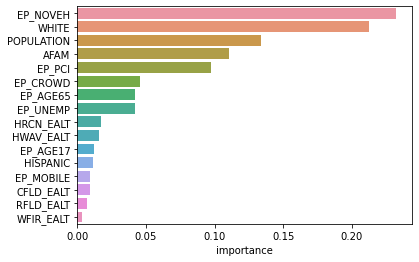

In [38]:
feature_imp = pd.DataFrame({'importance':best_model_rf_poi.feature_importances_},index = X_train.columns)
feature_imp = feature_imp.sort_values(by='importance',ascending=False)
sns.barplot(data = feature_imp,
            x = 'importance',
            y = feature_imp.index)
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


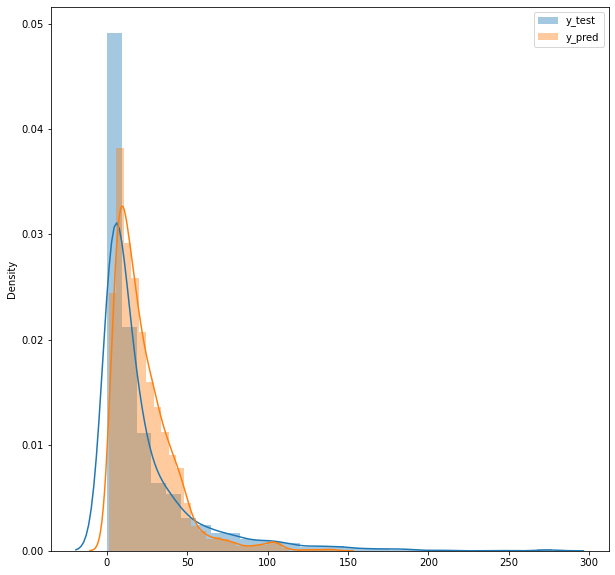

In [39]:
ax = plt.figure(figsize = (10,10))
sns.distplot(x = y_test,bins = 30,label = 'y_test')
sns.distplot(x = y_pred_rf_poi,bins = 30,label = 'y_pred')
plt.legend()
plt.show()

## Loss = MAE

In [42]:
pipe_rf_mae = Pipeline([('rf', RandomForestRegressor(n_estimators=200,
                                                n_jobs=-1,
                                                random_state = 12,
                                                criterion = 'absolute_error'
                                             )
                 )
                ])

In [43]:
max_features = np.unique(np.array([n,3*n/4,n/2,n/3,n/4,np.sqrt(n)])\
                                  .round()\
                                  .astype(int))
min_samples_leaf = 2**np.arange(5)

parameters = {'rf__max_features':max_features,
              'rf__min_samples_leaf':min_samples_leaf
             }



gcv_rf_mae = GridSearchCV(pipe_rf_mae,parameters,cv=10,scoring='neg_mean_absolute_error',verbose=2)
gcv_rf_mae.fit(X_train,y_train)
best_pipe_rf_mae = gcv_rf_mae.best_estimator_
best_pipe_rf_mae.fit(X_train,y_train)


Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=  56.2s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=  50.4s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=  50.1s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=  50.5s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=  49.8s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=  50.9s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=  54.1s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=  50.6s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=  51.5s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=  50.8s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=2; total time=  49.1s
[CV] END .........rf__max_features=4, rf__min_

[CV] END .........rf__max_features=8, rf__min_samples_leaf=1; total time= 1.6min
[CV] END .........rf__max_features=8, rf__min_samples_leaf=1; total time= 1.5min
[CV] END .........rf__max_features=8, rf__min_samples_leaf=1; total time= 1.6min
[CV] END .........rf__max_features=8, rf__min_samples_leaf=1; total time= 1.5min
[CV] END .........rf__max_features=8, rf__min_samples_leaf=1; total time= 1.6min
[CV] END .........rf__max_features=8, rf__min_samples_leaf=1; total time= 1.8min
[CV] END .........rf__max_features=8, rf__min_samples_leaf=1; total time= 1.6min
[CV] END .........rf__max_features=8, rf__min_samples_leaf=1; total time= 1.5min
[CV] END .........rf__max_features=8, rf__min_samples_leaf=1; total time= 1.6min
[CV] END .........rf__max_features=8, rf__min_samples_leaf=2; total time= 1.5min
[CV] END .........rf__max_features=8, rf__min_samples_leaf=2; total time= 1.5min
[CV] END .........rf__max_features=8, rf__min_samples_leaf=2; total time= 1.5min
[CV] END .........rf__max_fe

[CV] END ........rf__max_features=16, rf__min_samples_leaf=1; total time= 3.0min
[CV] END ........rf__max_features=16, rf__min_samples_leaf=1; total time= 3.0min
[CV] END ........rf__max_features=16, rf__min_samples_leaf=1; total time= 3.0min
[CV] END ........rf__max_features=16, rf__min_samples_leaf=1; total time= 3.0min
[CV] END ........rf__max_features=16, rf__min_samples_leaf=1; total time= 3.0min
[CV] END ........rf__max_features=16, rf__min_samples_leaf=1; total time= 3.0min
[CV] END ........rf__max_features=16, rf__min_samples_leaf=1; total time= 3.0min
[CV] END ........rf__max_features=16, rf__min_samples_leaf=2; total time= 2.9min
[CV] END ........rf__max_features=16, rf__min_samples_leaf=2; total time= 2.9min
[CV] END ........rf__max_features=16, rf__min_samples_leaf=2; total time= 2.9min
[CV] END ........rf__max_features=16, rf__min_samples_leaf=2; total time= 2.8min
[CV] END ........rf__max_features=16, rf__min_samples_leaf=2; total time= 2.8min
[CV] END ........rf__max_fea

Pipeline(steps=[('rf',
                 RandomForestRegressor(criterion='absolute_error',
                                       max_features=16, min_samples_leaf=8,
                                       n_estimators=200, n_jobs=-1,
                                       random_state=12))])

In [44]:
best_model_rf_mae = best_pipe_rf_mae['rf']

In [45]:
gcv_rf_mae.best_score_,best_model_rf_mae

(-11.457939688056875,
 RandomForestRegressor(criterion='absolute_error', max_features=16,
                       min_samples_leaf=8, n_estimators=200, n_jobs=-1,
                       random_state=12))

In [46]:
y_pred_rf_mae = best_model_rf_mae.predict(X_test)

In [47]:
mean_absolute_error(y_test,y_pred_rf_mae)

11.934486637347767

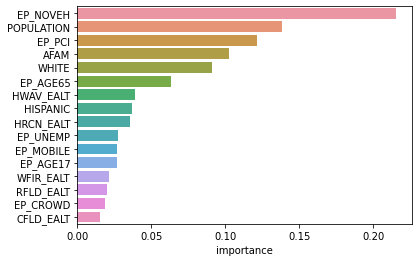

In [48]:
feature_imp = pd.DataFrame({'importance':best_model_rf_mae.feature_importances_},index = X_train.columns)
feature_imp = feature_imp.sort_values(by='importance',ascending=False)
sns.barplot(data = feature_imp,
            x = 'importance',
            y = feature_imp.index)
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


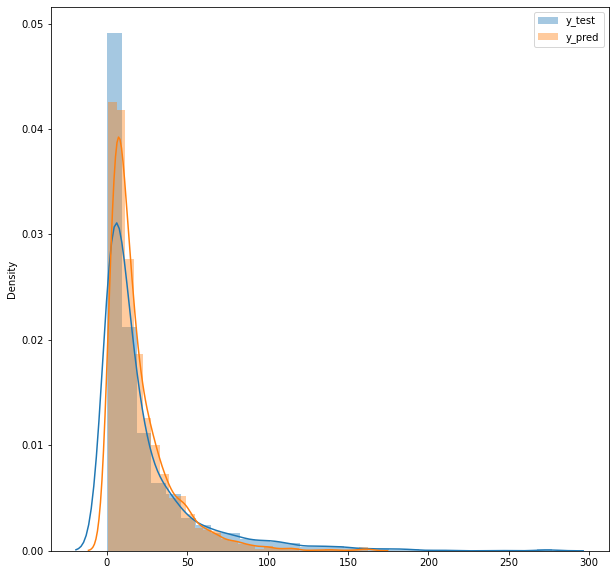

In [49]:
ax = plt.figure(figsize = (10,10))
sns.distplot(x = y_test,bins = 30,label = 'y_test')
sns.distplot(x = y_pred_rf_mae,bins = 30,label = 'y_pred')
plt.legend()
plt.show()

In [50]:
from sklearn.inspection import permutation_importance
r = permutation_importance(best_model_rf_mae, X_test, y_test,
                           n_repeats=100,
                           random_state=0,scoring='neg_mean_absolute_error')

In [107]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{X_train.columns[i]:<8}"
               f" {r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")
    else:
        print('abc')

POPULATION 3.092 +/- 0.150
EP_NOVEH 2.618 +/- 0.115
WHITE    1.501 +/- 0.100
EP_PCI   1.488 +/- 0.104
AFAM     1.470 +/- 0.109
EP_AGE65 0.663 +/- 0.060
HWAV_EALT 0.443 +/- 0.062
WFIR_EALT 0.245 +/- 0.023
EP_MOBILE 0.212 +/- 0.029
HRCN_EALT 0.209 +/- 0.024
HISPANIC 0.189 +/- 0.028
EP_AGE17 0.134 +/- 0.014
EP_UNEMP 0.122 +/- 0.020
CFLD_EALT 0.075 +/- 0.016
EP_CROWD 0.071 +/- 0.012
RFLD_EALT 0.045 +/- 0.011
